$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$


# Reinforcement Learning with Neural Network Function Approximation



So far, we have learned about the reinforcement learning and how we can implement temporal difference learning with tabular function approximation. 
Here, we observed that the table cannot hold all the information when the number of states or actions is very large. 
Not only for the memory, but the time to take until it fills out the cells correctly can matter.
We refer this issue as *generalization*. 
The question that we will discuss is how to generalize to produce a good estimation over unexperienced state space based on the experience from the limited set of the state space.

This kind of generalization is called as *function approximation*. 
For this, we do not reinvent wheels for reinforcement learning. Lots of study in supervised learning already suggested various techniques including artificial neural networks, which we have learned last week. 



## Example problem in continuous state space



In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import collections
from copy import deepcopy as copy

from util import Standardizer

In [20]:
class Marble():
    """ 1d marble problem
        
        states: x, dx
        action: action [-1,1]


        |            ___                     |
        |___________|///|____G_______________|
                    <- ->
    """

    def __init__(self, goal=5, **params):
        self.n_state = 2
        self.n_action = 1
        self.Goal = goal
        self.bound = params.pop('bound', [0, 10, -5, 5])
        if len(self.bound) != 4:
             self.bound = self.bound[:2] + [-5, 5]

        self._st_range = np.array([self.bound[:2], self.bound[2:], [-1, 1]]).T
        self.nnNI = self.n_state + 1
        self.goal_width = 1
        
        self._s = [0, 0]

    def init(self, start=None):
        if start is not None:
            self._s = start
        else: 
            self._s = [np.random.randint(self.bound[0], self.bound[1]), 0.]
        return self._s
       
    def get_random_action(self):
        return float(np.random.randint(3) - 1) # discrete action

    def get_bound_act(self, a):
        if a[0] > 1:
            return 1
        elif a[0] < -1:
            return -1
        else:
            return a[0]

    def next(self, a) :
        s = self._s
        if isinstance(a, collections.Iterable):
            a = a[0]
        s1 = copy(s)
        dT = 0.1
        s1[0] += dT * s[1]  # get new pos
        s1[1] += dT * ( 2*a - 0.2 * s[1] )  # get new velocity

        # adjust velocity when outside of the track
        if s1[0] < self.bound[0]:
            s1[:]  = [self.bound[0], 0]
        elif s1[0] > self.bound[1] :
            s1[:] = [self.bound[1], 0]
        # clipping the velocity
        s1[1] = np.clip(s1[1], self._st_range[0, 1],
                               self._st_range[1, 1])

        self._s =  s1
        return self.get_reward(s, s1, a)

    def get_cur_state(self):
        return self._s

    def get_reward(self,s,s1,a):
        return 1 if abs(s1[0] - self.Goal) < self.goal_width else 0

    def get_state_range(self):
        return self._st_range

    def get_actions(self):
        return np.array([-1., 0., 1.])

    def get_action_index(self, action):
        return np.where(np.array([-1, 0, 1]) == action)[0][0]

    def draw_trajectory(self, smplX):
        if smplX.shape[1] == 1: return
        plt.plot(smplX[:,0],smplX[:,1])
        plt.axis([self.bound[0], self.bound[1],-5,5])
        plt.plot(smplX[0,0],smplX[0,1],'go')
        plt.plot(self.Goal,0,'ro')
        # draw a goal region
        plt.fill_between([self.Goal-self.goal_width, self.Goal+self.goal_width],
                         [-5,-5], [5,5],
                         color="red", alpha=0.3)
        plt.xlabel("s") 
        plt.ylabel("s dot")

In [21]:
class Marble1D():
    """ 1d marble problem
        
        states: x, dx
        action: action [-1,1]


        |            ___                     |
        |___________|///|____G_______________|
                    <- ->
    """

    def __init__(self, goal=5, bound=[0, 10, -5, 5]):
        """ Initializes the marble game board
        
        goal (float): x position of goal where marble must within self.goal_width 
            of this goal to complete the task.
        
        bound (list): Contains bounds for marble game.
            [x lower boundary, x upper boundary, min x negative velocity, max x positive velocity]
        """
        # Number of state features
        self.n_state = 2
        
        # Number of actions. This seems to never be 
        # used and seems wrong as we have 3 actions [-1, 0, 1]???
        self.n_action = 1
        
        # Location of goal given by its x position 
        self.Goal = goal
        
        # Sets boundaries for x and dx velocity 
        self.bound = bound
        
        # I think this tries to set defaults if bad input for
        # bound is given??? Can probably comment out or ignore it.
        if len(self.bound)!= 4:
             self.bound = self.bound[:2] + [-5, 5]
                
        # Creates an array where the 1st row contains min values and the 2nd row
        # contains max vaules. Not sure if min and max action matter, this
        # seems useful only for continuous actions only???
        # [[ x lower boundary, min x negative velocity, min action]
        # [x upper boundary, max x positive velocity, max action]]
        self._st_range = np.array([self.bound[:2], self.bound[2:], [-1, 1]]).T
        
        # Never used????
        self.nnNI = self.n_state + 1
        
        # Used check if marble is within a certain distance of the goal
        self.goal_width = 1
        
        # Initialize start state in case self.init isn't called
        # s[0] = x position
        # s[1] = dx or velocity in the x direction
        self._s = [0, 0]

    def init(self, start=None):
        """Initializes starting state for board      
           
           If you want to set a specific starting state or
           a random one call this funtion!
           
           Args:
               start (list): start[0] should contain the starting x 
                   position of the marble and s[1] should contain the
                   starting dx velocity. 
        """
        if start is not None:
            # Set start state to passed x and dx 
            self._s = start
        else: 
            # Randomly select start position between x bounds
            self._s = [np.random.randint(self.bound[0], self.bound[1]), 0.]
        return self._s
       
    def get_random_action(self):
        """ Randomly select a discrete action INDEX
            
            WARNING: Hardcoded for 3 actions 
        """
        return float(np.random.randint(3) -1) 

    def get_bound_act(self, a):
        """Never used???"""
        if a[0] > 1:
            return 1
        elif a[0] < -1:
            return -1
        else:
            return a[0]

    def next(self, a) :
        """ Given an action moves state s to next state s1
        
            Args:
                a (numeric): Action taken whose value can be
                    -1 for moving left, 0 for no movement, or 1
                    for moving right.
        
            Returns:
                Reward given marble is within goal location bounds
        """
        # Store curent state
        s = self._s
        
        # Not sure why this is here but if object is iterable
        # then it selects the first index.
        if isinstance(a, collections.Iterable):
            a = a[0]
            
        # Copies current state values into next state 
        # so they can be updated.
        s1 = copy(s)
        # Set velocity variable for increasing velocity over time
        dT = 0.1
        
        # Update x position
        s1[0] += dT * s[1] 
        # Update dx velocity (i.e., velocity of x)
        s1[1] += dT * (2*a - 0.2*s[1])
        
        # Adjust x velocity when hitting the bounds
        # or the sides of the case/track. Set veloctiy 
        # to 0 and set x position equal to the x bound.
        if s1[0] < self.bound[0]:
            s1[:] = [self.bound[0], 0]
        elif s1[0] > self.bound[1] :
            s1[:] = [self.bound[1], 0]

        # Clips velocity in postive and negative x direction
        s1[1] = np.clip(s1[1], self._st_range[0, 1],
                               self._st_range[1, 1])

        # Set next state equal to current state
        self._s =  s1
        
        return self.get_reward(s=s, a=a, s1=s1)

    def get_cur_state(self):
        """Returns the current state features"""
        return self._s

    def get_reward(self, s, s1, a):
        """ Returns current reward
            
            If marble's next state s1 is within a certain distance
            of the goal then a positive reward of 1 is given,
            else 0 reward is given. The distance to the goal in order 
            to recieve a positive reward is determined by self.goal_width.
        """
        return 1 if abs(s1[0] - self.Goal) < self.goal_width else 0

    def get_state_range(self):
        """ Returns state min and max values
        
            This is basically the same as self.boundaries 
            but given as an NumPy array.
        """
        return self._st_range

    def get_actions(self):
        """ Return all possible actions
            
            Notes:
                move left = -1
                don't move = 0
                move right = 1
            
        """
        return np.array([-1., 0., 1.])

    def get_action_index(self, action):
        """ Returns index of a selected action
        
            Notes:
                Be aware all actions are hardcoded! 
        """
        return np.where(np.array([-1, 0, 1]) == action)[0][0]

    def draw_trajectory(self, smplX):
        """ Never used???"""
        if smplX.shape[1] == 1: return
        plt.plot(smplX[:,0],smplX[:,1])
        plt.axis([self.bound[0], self.bound[1],-5,5])
        plt.plot(smplX[0,0],smplX[0,1],'go')
        plt.plot(self.Goal,0,'ro')
        # draw a goal region
        plt.fill_between([self.Goal-self.goal_width, self.Goal+self.goal_width],
                         [-5,-5], [5,5],
                         color="red", alpha=0.3)
        plt.xlabel("s") 
        plt.ylabel("s dot")

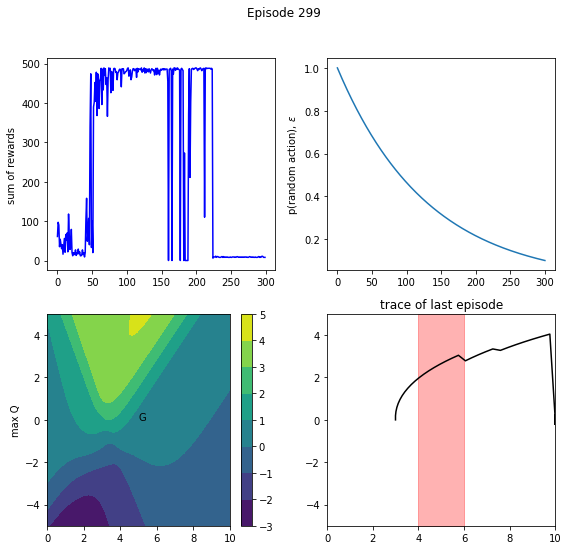

In [23]:
## Parameters
K = 300
n_actions = 3 
max_steps = 500
gamma = 0.9
verbose = False

epsilon = 1.
final_epsilon = 0.1
epsilon_decay =  np.exp(np.log(final_epsilon) / K)

####################
nHiddens = 5
nSamples = 1
nOutputs = 1
nInputs = 3
max_iter = 10

rhoh = rhoo = 0.01

rh = rhoh / (nSamples*nOutputs)
ro = rhoo / (nSamples*nOutputs)

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(nInputs+1,nHiddens))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+nHiddens,nOutputs))-0.5)

# Add constant column of 1's
def addOnes(A):
    return np.insert(A, 0, 1, axis=len(np.array(A).shape)-1)

def forward(X):
    X = stdX.standardize(X)
    # Forward pass on training data
    X1 = addOnes(X)
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W
    return Y, Z

def as_array(A):
    A = np.array(A)
    if len(A.shape) == 1:
        return A.reshape((1, -1))
    return A

def backward(error, Z, X):
    
    ### make sure the array shapes
    X = as_array(X)
    Z = as_array(Z)
    E = as_array(error)
    
    Z1 = addOnes(Z)
    X1 = addOnes(X)

    # Backward pass - the backpropagation and weight update steps
    dV = rh * X1.T @ ( ( E @ W[1:,:].T) * (1-Z**2))
    dW = ro * Z1.T @ E
    return dV, dW


def epsilon_greedy(e, s):
    if np.random.rand() < e:
        return np.random.randint(n_actions) - 1
    else:
        Q, _ = forward(np.hstack((np.tile(s, (3,1)), env.get_actions().reshape((-1, 1)))))
        max_as = np.where(Q == np.max(Q))[0] - 1 # index to action value
        return np.random.choice(max_as)
        

fig = plt.figure(figsize=(8, 8))
####################
# Cart model environment 
env = Marble1D()

####################
# Normalize 
stdX = Standardizer(env.get_state_range())


# rewards and step trace
rtrace = []
etrace = [epsilon]
for j in range(K):

    if verbose: print("\tepisode #", j, "   ",end="")
    env.init([3,0]) #[float(np.random.randint(-5, 5, 1)), 0])
    s = env.get_cur_state()
    # selection an action
    a = epsilon_greedy(epsilon, s)

    rewards = []
    trace = np.array(s)
    for step in range(max_steps):
        if verbose: print("\tstep #", step, "   ",end="")
        # move
        r1 = env.next(a)
        s1 = env.get_cur_state()
        a1 = epsilon_greedy(epsilon, s1)

        rewards.append(r1)
        trace = np.vstack((trace, s1))

        # update neural networks
        Q1, _ = forward(np.hstack((s1, a1)))  # output of neural network is Q for next state
        Q, Z = forward(np.hstack((s, a)))  # output of neural network is Q for next state
        error = r1 + gamma * Q1 - Q  # use action value as index by adding one
        dV, dW = backward(error, Z, np.hstack((s, a)))
        V += dV
        W += dW

        s = s1
        a = a1
        
    epsilon *= epsilon_decay
    etrace.append(epsilon)


    if verbose: print("Done (", np.sum(rewards), ")", step)

    rtrace.append(np.sum(rewards))

    last_plot = (j == K-1)
    
    if j % 10 == 0 or last_plot:
        plt.clf()
        fig.add_subplot(221)
        plt.plot(rtrace, "b-")
        plt.ylabel("sum of rewards")

        fig.add_subplot(222)
        plt.plot(etrace, "-")
        plt.ylabel("p(random action), $\epsilon$")

        # contour plot for Q
        fig.add_subplot(223)
        xs, ys = np.meshgrid(np.linspace(0, 10, 100), np.linspace(-5, 5, 100))

        X = np.vstack((xs.flat, ys.flat)).T

        Q = np.array([forward(np.hstack((x, a)))[0] for a in [-1, 0, 1] for x in X])

        maxQ = np.max(Q.reshape((3, -1)), axis=0)
        cs = plt.contourf(xs, ys, maxQ.reshape(xs.shape))
        plt.colorbar(cs)
        plt.text(env.Goal, 0, 'G')
        plt.ylabel("max Q")

        # plot traces
        fig.add_subplot(224)
        plt.plot(trace[:, 0], trace[:, 1], "k-")
        plt.fill_between([env.Goal-1, env.Goal+1], [-5, -5],[5, 5], color='red', alpha=0.3)
        plt.title("trace of last episode")
        plt.xlim([0, 10])
        plt.ylim([-5, 5])

        plt.suptitle(''.join(["Episode ",str(j)]))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.draw()

        ipd.clear_output(wait=True)
        ipd.display(fig)
ipd.clear_output(wait=True)

In [24]:
def testIt(nTrials,nStepsPerTrial):
    xs = np.linspace(0,10,nTrials)
    for x in xs:
        s = env.init([x,0]) ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a = epsilon_greedy(0, s) # epsilon = 0
            env.next(a)
            s = env.get_cur_state()
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([5,5],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

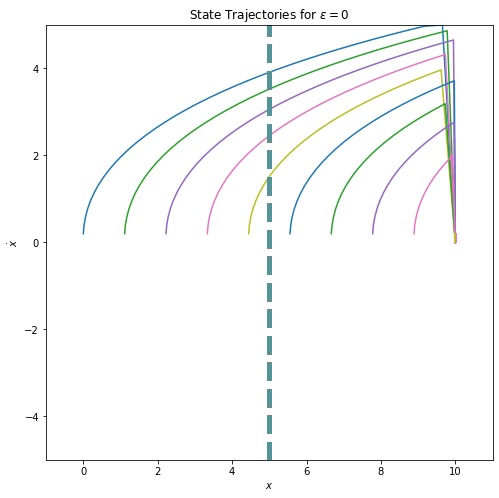

In [25]:
plt.figure(figsize=(8,8))
testIt(10, 100)